<a href="https://colab.research.google.com/github/OlhaDot/NewProjectStadyAcademy/blob/master/lesson_55.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [2]:
noise_dim = 100
latent_dim = 100
batch_size = 100

In [3]:
# 1. завантаження набір даних MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

100%|██████████| 9912422/9912422 [00:00<00:00, 101251555.57it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 53246458.82it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26866699.29it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16352385.21it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
# 2. створіть генератор
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), 1, 28, 28)
        return x

generator = Generator()


In [5]:
# створіть дискримінатор
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x

discriminator = Discriminator()


In [6]:
# Втрата дискримінатора
criterion = nn.BCELoss()

# Оптимізатори
lr = 0.0002
generator_optimizer = optim.Adam(generator.parameters(), lr=lr)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr)

In [8]:
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_dataloader):
        real_images = real_images.to(device)

        # Навчання дискримінатора
        discriminator.zero_grad()
        real_labels = torch.ones(real_images.size(0), 1).to(device)
        real_output = discriminator(real_images)
        real_loss = criterion(real_output, real_labels)

        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_images = generator(noise)
        fake_labels = torch.zeros(fake_images.size(0), 1).to(device)
        fake_output = discriminator(fake_images.detach())
        fake_loss = criterion(fake_output, fake_labels)

        discriminator_loss = real_loss + fake_loss
        discriminator_loss.backward()
        discriminator_optimizer.step()

        # Навчання генератора
        generator.zero_grad()
        fake_output = discriminator(fake_images)
        generator_loss = criterion(fake_output, real_labels)

        generator_loss.backward()
        generator_optimizer.step()

        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_dataloader)}], "
                  f"Discriminator Loss: {discriminator_loss.item():.4f}, "
                  f"Generator Loss: {generator_loss.item():.4f}")



Epoch [1/100], Step [100/600], Discriminator Loss: 0.3151, Generator Loss: 5.7082
Epoch [1/100], Step [200/600], Discriminator Loss: 0.5446, Generator Loss: 5.3652
Epoch [1/100], Step [300/600], Discriminator Loss: 0.0344, Generator Loss: 5.0194
Epoch [1/100], Step [400/600], Discriminator Loss: 0.0993, Generator Loss: 7.5472
Epoch [1/100], Step [500/600], Discriminator Loss: 0.1678, Generator Loss: 6.3944
Epoch [1/100], Step [600/600], Discriminator Loss: 0.5324, Generator Loss: 7.3837
Epoch [2/100], Step [100/600], Discriminator Loss: 0.2365, Generator Loss: 6.3084
Epoch [2/100], Step [200/600], Discriminator Loss: 0.5021, Generator Loss: 4.3035
Epoch [2/100], Step [300/600], Discriminator Loss: 0.5455, Generator Loss: 9.2912
Epoch [2/100], Step [400/600], Discriminator Loss: 0.2566, Generator Loss: 3.6716
Epoch [2/100], Step [500/600], Discriminator Loss: 0.3188, Generator Loss: 5.9571
Epoch [2/100], Step [600/600], Discriminator Loss: 0.2107, Generator Loss: 6.9517
Epoch [3/100], S

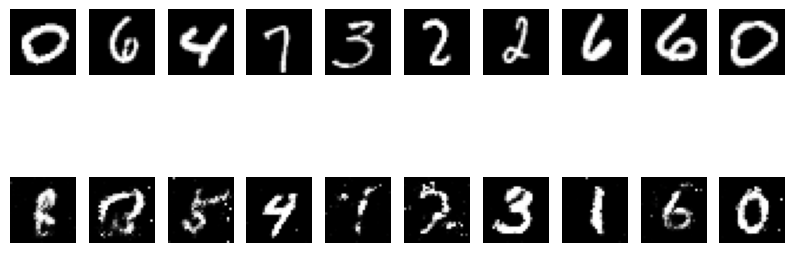

In [10]:
# Генерування зображень з генератора
num_samples = 10
noise = torch.randn(num_samples, noise_dim).to("cpu")
generated_images = generator(noise).detach().cpu()

# Відображення оригінальних зображень з MNIST
real_images, _ = next(iter(train_dataloader))
real_images = real_images[:num_samples]

# Відображення згенерованих та оригінальних зображень
fig, axes = plt.subplots(nrows=2, ncols=num_samples, figsize=(10, 4))
for i in range(num_samples):
    axes[0][i].imshow(real_images[i].squeeze(), cmap='gray')
    axes[0][i].axis('off')
    axes[1][i].imshow(generated_images[i].squeeze(), cmap='gray')
    axes[1][i].axis('off')

plt.show()